In [1]:
# Import libraries with Plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode

# Initialize Plotly in notebook mode
init_notebook_mode(connected=True)

# Set up for better display
pd.set_option('display.max_columns', None)

In [2]:
# Load processed data
df = pd.read_csv('../data/processed/final_dataset.csv')

df.rename(columns={
    'GDP_current_US$': 'gdp',
    'Military_expenditure_%_of_GDP': 'mil_exp_pct',
    'Population_total': 'population'
}, inplace=True)

In [3]:
# Yearly trends using TIV
yearly_tiv_summary = df.groupby('year').agg({
    'tiv_total_order': 'sum',
    'tiv_delivered': 'sum',
    'country': 'nunique'
}).reset_index()
yearly_tiv_summary['year'] = yearly_tiv_summary['year'].astype(str)  # Convert year to string
fig = px.line(yearly_tiv_summary, x='year', y='tiv_total_order',
              title='Total Arms Trade Volume (TIV) by Year (2020-2023)',
              labels={'tiv_total_order': 'Total TIV Ordered', 'year': ''},
              markers=True)
fig.update_traces(line=dict(width=4))
fig.show()

In [4]:
# Top importers using TIV with mean for economic metrics
country_tiv_totals = df.groupby('country').agg({
    'tiv_total_order': 'sum',
    'tiv_delivered': 'sum',
    'gdp': 'mean',           
    'mil_exp_pct': 'mean',   
    'population': 'mean',    
    'units_ordered': 'sum'
}).reset_index()

fig = px.bar(country_tiv_totals.nlargest(10, 'tiv_total_order'), 
             x='tiv_total_order', y='country',
             title='Top 10 Arms Importers by TIV Ordered (2020-2023)',
             hover_data=['tiv_delivered', 'units_ordered', 'gdp', 'mil_exp_pct', 'population'],
             labels={'tiv_total_order': 'TIV Ordered', 'country': ''},
             color='tiv_total_order',
             color_continuous_scale='viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

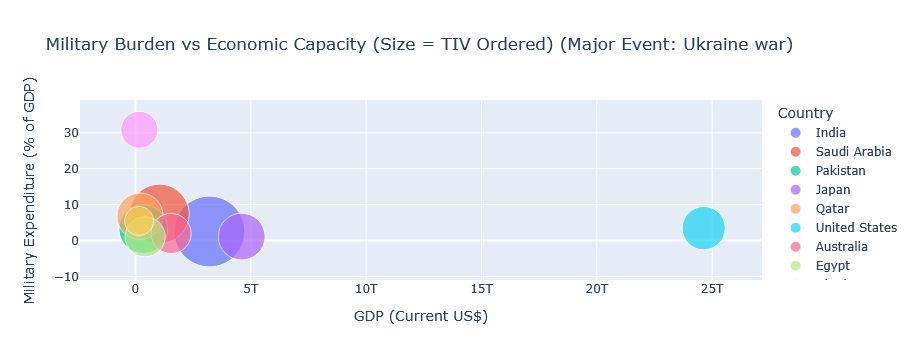

In [5]:
# Military burden analysis
fig = px.scatter(country_tiv_totals.nlargest(10, 'tiv_total_order'),
                 x='gdp', y='mil_exp_pct',
                 size='tiv_total_order',
                 color='country',
                 hover_name='country',
                 hover_data=['population'],
                 title='Military Burden vs Economic Capacity (Size = TIV Ordered) (Major Event: Ukraine war)',
                 labels={'country': 'Country',
                         'gdp': 'GDP (Current US$)',
                         'mil_exp_pct': 'Military Expenditure (% of GDP)',
                         'tiv_total_order': 'TIV Ordered',
                         'population': 'Population'},
                 size_max=50)
fig.show()

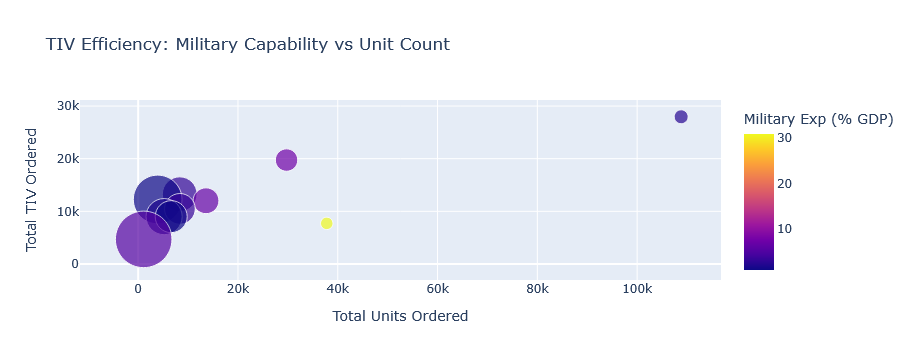

In [6]:
# TIV efficiency with mean aggregation
tiv_efficiency = df.groupby('country').agg({
    'tiv_total_order': 'sum',
    'units_ordered': 'sum',
    'tiv_per_unit': 'mean',
    'gdp': 'mean',           
    'mil_exp_pct': 'mean'   
}).reset_index()

tiv_efficiency['tiv_per_unit_overall'] = tiv_efficiency['tiv_total_order'] / tiv_efficiency['units_ordered']

fig = px.scatter(tiv_efficiency.nlargest(20, 'tiv_total_order'),
                 x='units_ordered', y='tiv_total_order',
                 size='tiv_per_unit_overall',
                 color='mil_exp_pct',
                 hover_name='country',
                 hover_data=['gdp', 'tiv_per_unit_overall'],
                 title='TIV Efficiency: Military Capability vs Unit Count',
                 labels={'units_ordered': 'Total Units Ordered',
                        'tiv_total_order': 'Total TIV Ordered',
                        'tiv_per_unit_overall': 'Avg TIV per Unit',
                        'mil_exp_pct': 'Military Exp (% GDP)',
                        'gdp': 'GDP'},
                 size_max=40)
fig.show()

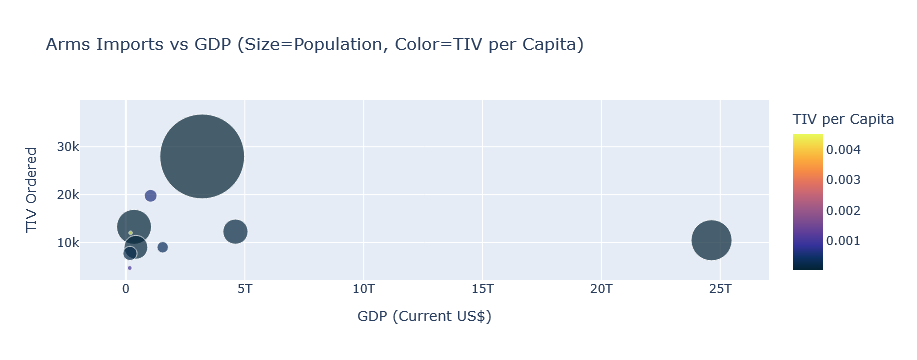

In [7]:
# Population analysis with mean aggregation
country_tiv_totals['tiv_per_capita'] = country_tiv_totals['tiv_total_order'] / country_tiv_totals['population']
country_tiv_totals['tiv_per_gdp'] = country_tiv_totals['tiv_total_order'] / country_tiv_totals['gdp']

fig = px.scatter(country_tiv_totals.nlargest(20, 'tiv_total_order'),
                 x='gdp', y='tiv_total_order',
                 size='population',
                 color='tiv_per_capita',
                 hover_name='country',
                 hover_data=['mil_exp_pct', 'tiv_per_gdp'],
                 title='Arms Imports vs GDP (Size=Population, Color=TIV per Capita)',
                 labels={'gdp': 'GDP (Current US$)',
                        'tiv_total_order': 'TIV Ordered',
                        'population': 'Population',
                        'tiv_per_capita': 'TIV per Capita',
                        'tiv_per_gdp': 'TIV per GDP',
                        'mil_exp_pct': 'Military Exp %'},
                 size_max=60,
                 color_continuous_scale='thermal')
fig.show()

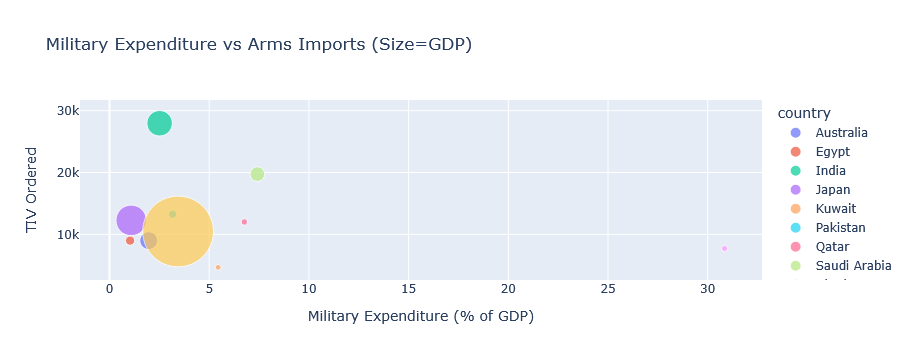

In [8]:
# Focus on military spending relationships
fig = px.scatter(country_tiv_totals, 
                 x='mil_exp_pct', y='tiv_total_order',
                 size='gdp',
                 color='country',
                 hover_name='country',
                 hover_data=['population', 'tiv_delivered'],
                 title='Military Expenditure vs Arms Imports (Size=GDP)',
                 labels={'mil_exp_pct': 'Military Expenditure (% of GDP)',
                        'tiv_total_order': 'TIV Ordered',
                        'gdp': 'GDP'},
                 size_max=50)
fig.show()

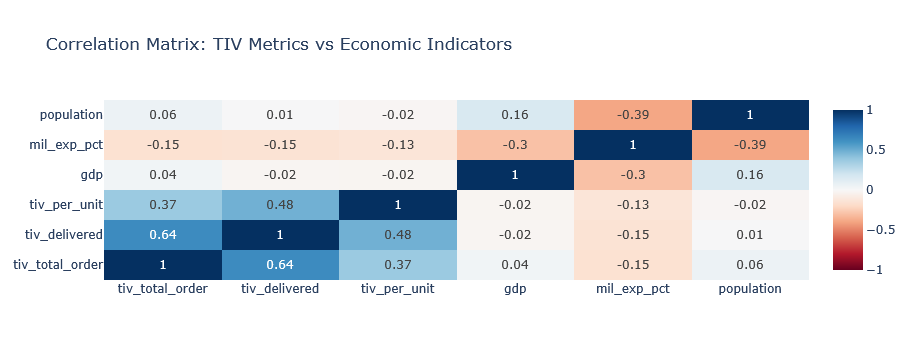

In [9]:
# Correlation analysis with clean names
tiv_correlation_cols = ['tiv_total_order', 'tiv_delivered', 'tiv_per_unit',
                       'gdp', 'mil_exp_pct', 'population']
available_tiv_corr = [col for col in tiv_correlation_cols if col in df.columns]

corr_matrix = df[available_tiv_corr].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmid=0,
    text=corr_matrix.round(2).values,
    texttemplate="%{text}",
    textfont={"size": 12}
))

fig.update_layout(title='Correlation Matrix: TIV Metrics vs Economic Indicators')
fig.show()

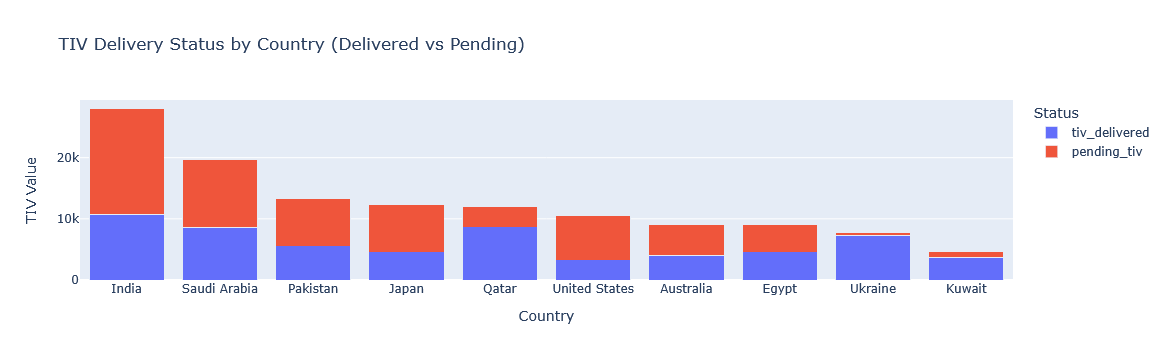

In [10]:
# Delivery analysis with mean aggregation
delivery_analysis = df.groupby('country').agg({
    'tiv_total_order': 'sum',
    'tiv_delivered': 'sum',
    'gdp': 'mean',           
    'mil_exp_pct': 'mean'    
}).reset_index()

delivery_analysis['delivery_ratio'] = (delivery_analysis['tiv_delivered'] / delivery_analysis['tiv_total_order']) * 100
delivery_analysis['pending_tiv'] = delivery_analysis['tiv_total_order'] - delivery_analysis['tiv_delivered']

fig = px.bar(delivery_analysis.nlargest(15, 'tiv_total_order'),
             x='country', y=['tiv_delivered', 'pending_tiv'],
             title='TIV Delivery Status by Country (Delivered vs Pending)',
             labels={'value': 'TIV Value', 'country': 'Country', 'variable': 'Status'},
             hover_data=['gdp', 'mil_exp_pct'],
             barmode='stack')
fig.show()